In [1]:
#imports

import os
import json
import hoomd
import codecs
import cooltools

import numpy as np
import matplotlib.pyplot as plt

import polychrom_hoomd.log as log
import polychrom_hoomd.build as build
import polychrom_hoomd.forces as forces
import polychrom_hoomd.render as render
import polychrom_hoomd.extrude as extrude


from lattice_translocators.generators.Translocator import Translocator
from lattice_translocators.engines.SymmetricExtruder import SymmetricExtruder


from polykit.analysis import polymer_analyses, contact_maps
from polykit.generators.initial_conformations import create_random_walk

In [2]:
def tune_rbuff(sim, nl, steps, buffer_min, buffer_max, Nbins, set_r_buff, set_check_period):
    r_buffs = np.round(np.linspace(buffer_min, buffer_max, Nbins), 3)
    TPSs = []
    shortest_rebuilds = []
    print(f'Staring tune of buffer size for the neighboring \n')
    print(f'r-buff in {r_buffs} \n')

    for r_buff in r_buffs:
        print(f'buffer size = {r_buff} \n')
        nl.buffer = r_buff
        print(f'starting run for {steps} steps \n')
        sim.run(steps)
        print(f'for buffer size = {r_buff}, TPS = {sim.tps} \n, shortest rebuild = {nl.shortest_rebuild} \n')
        TPSs.append(sim.tps)
        shortest_rebuilds.append(nl.shortest_rebuild)

    best_r_buff = r_buffs[TPSs.index(max(TPSs))]
    best_shortest_rebuild = shortest_rebuilds [TPSs.index(max(TPSs))]
    print(f'The best buffer size is: {best_r_buff} with a TPS of {max(TPSs)} and shortest rebuild = {best_shortest_rebuild} \n')
    if set_r_buff == True:
        print(f'setting buffer size to {best_r_buff} \n')
        nl.buffer = best_r_buff
    if set_check_period:
        print(f'setting rebuuld check delay to {best_shortest_rebuild - 2} \n')
        nl.rebuild_check_delay = best_shortest_rebuild - 2
    return best_r_buff, best_shortest_rebuild

In [3]:
# Initialize empty simulation object
hoomd_device = build.get_hoomd_device()
# Generate RNG seed
rng_seed = os.urandom(2)
rng_seed = int(codecs.encode(rng_seed, 'hex'), 16)

print("Using entropy-harvested random seed: %d" % rng_seed)
system = hoomd.Simulation(device=hoomd_device, seed=rng_seed)

notice(2): Setting number of TBB threads to value of OMP_NUM_THREADS=1
HOOMD is running on the following GPU(s):
[0]NVIDIA GeForce RTX 4090 128 SM_8.9 @ 2.62 GHz, 24217 MiB DRAM
[1]NVIDIA GeForce RTX 4090 128 SM_8.9 @ 2.62 GHz, 24217 MiB DRAM
Using entropy-harvested random seed: 16461


In [4]:
#Create simulation from snapshot: Setup bonds, monomer types and initial positions 
N = 1000
L = 1000
snapshot = build.get_simulation_box(box_length=L)
# Build random, dense initial conformations
monomer_positions = create_random_walk(step_size=1, N=N)

# Read input force parameters
with open("force_dict_full.json", 'r') as dict_file:
    force_dict = json.load(dict_file)


#read bond and monomer types from force_dict
bond_types = force_dict['Bonded forces'].keys()
monomer_types = force_dict['Non-bonded forces']['Attraction']['Matrix'].keys()
# monomer_types = ['A']

build.set_chains(snapshot, monomer_positions, N, monomer_type_list=list(monomer_types), bond_type_list=list(bond_types))

# Setup sticky probe positions by assigning monomers to a type 0 backbone or 1 probes
probe_position_1 = 50
probe_position_2 = 450

# set position of sticky probes
typeid = np.zeros(N)
typeid[probe_position_1 : probe_position_1 +10], typeid[probe_position_2 : probe_position_2 +10] = 1, 1 
snapshot.particles.typeid[:] = typeid

# Populate snapshot with the generated chains
# Quickly visualize starting conformation using the Fresnel backend
render.fresnel(snapshot, cmap="Spectral").static(pathtrace=False)
# Setup HooMD simulation object
system.create_state_from_snapshot(snapshot)

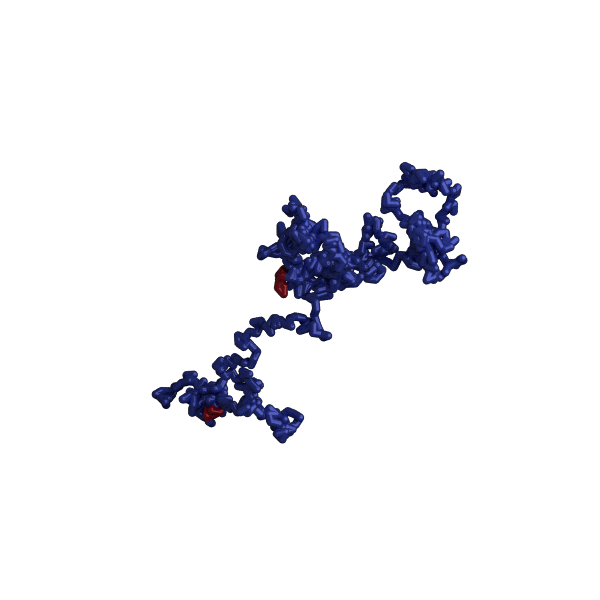

In [5]:
# Visualize new conformation
snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [6]:
### Setup forces

# Setup neighbor list
nl = hoomd.md.nlist.Tree(buffer=1)

# Set chromosome excluded volume
repulsion_forces = forces.get_repulsion_forces(nl, **force_dict)
bonded_forces = forces.get_bonded_forces(**force_dict)
attraction_forces = forces.get_attraction_forces(nl, **force_dict)

force_field = repulsion_forces + bonded_forces# + attraction_forces

In [7]:
# Initialize integrators and Langevin thermostat
gamma=1
langevin = hoomd.md.methods.Langevin(filter=hoomd.filter.All(), kT=1.0)
langevin.gamma.default = gamma
integrator = hoomd.md.Integrator(dt=0.05, methods=[langevin], forces=force_field)
logger = log.get_logger(system)

system.operations.integrator = integrator
system.operations.writers.append(log.table_formatter(logger, period=1e4))

In [8]:
#thermalize system
Nthermalize=5e4
system.run(Nthermalize)

Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           5694.38591     0:00:07.024462           1.05730          
       20000           6553.50169     0:00:04.577705           1.06450          
       30000           6930.34585     0:00:02.885859           0.97304          
       40000           7133.42932     0:00:01.401850           1.03530          
       50000           7265.36190        0:00:00               1.00564          


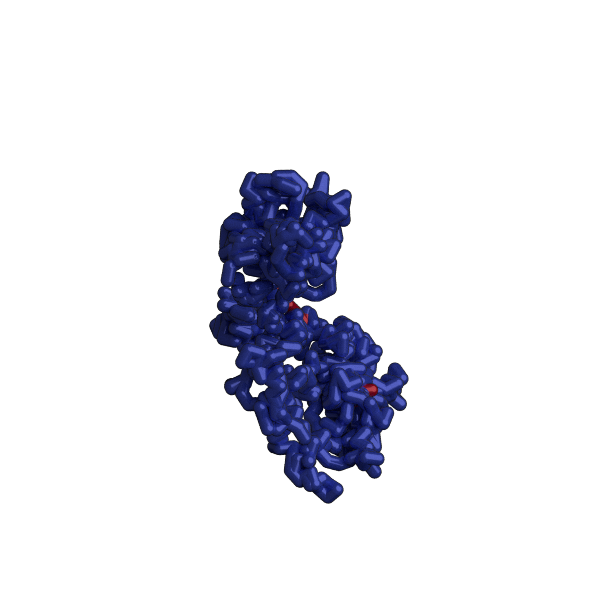

In [7]:
# Visualize new conformation

snapshot_relaxed = system.state.get_snapshot()
render.fresnel(snapshot_relaxed, show_compartments=True, cmap="coolwarm").static(pathtrace=True)

In [11]:
tune_rbuff(system, nl, steps = 100_000, buffer_min=3, buffer_max=5, Nbins=10, set_r_buff=True, set_check_period=False)

Staring tune of buffer size for the neighboring 

r-buff in [3.    3.222 3.444 3.667 3.889 4.111 4.333 4.556 4.778 5.   ] 

buffer size = 3.0 

starting run for 100000 steps 

       90000           9378.18801     0:00:09.676816           1.01267          
      100000           9653.02181     0:00:08.365360           1.00838          
      110000           9653.01236     0:00:07.329422           1.04270          
      120000           9659.05134     0:00:06.289541           1.07033          
      130000           9642.99875     0:00:05.262989           1.00694          
      140000           9645.96721     0:00:04.224667           1.02046          
      150000           9612.60032     0:00:03.199030           1.05575          
      160000           9594.32128     0:00:02.162842           1.05759          
      170000           9582.25068     0:00:01.121970           1.01676          
      180000           9564.97335     0:00:00.078516           1.01511          
for buffer siz

(4.333, 10)

In [8]:
Nsteps = 300e6
Nframes = 50_000
period = int(Nsteps/Nframes)

filename = f'data/trajectory_N{system.state.get_snapshot().particles.N}.gsd'
gsd_writer = hoomd.write.GSD(filename=filename, trigger=hoomd.trigger.Periodic(period), mode='wb')
system.operations.writers.append(gsd_writer)

system.run(Nsteps)

notice(3): GSD: create or overwrite gsd file data/trajectory_N1000.gsd
Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
       10000           7521.81167    11:04:42.678934           1.02323          
       20000           8430.44284     9:53:02.946911           1.02589          
       30000           9017.10572     9:14:26.771993           1.02994          
       40000           9160.05676     9:05:46.521987           1.05173          
       50000           9292.09888     8:58:00.112794           1.01925          
       60000           9492.59494     8:46:37.261010           0.98569          
       70000           9576.53333     8:41:59.266560           1.05663          
       80000           9663.14461     8:37:17.515444           1.05260          
       90000           9754.01721     8:32:27.331439           1.00324          
      100000           9802.64529     8:29:53.782712           1.04871          
      110000           9831.52633     

# EXTRUSION

In [179]:
# Parse extrusion parameters
with open("extrusion_dict.json", 'r') as dict_file:
    extrusion_dict = json.load(dict_file)

# Create some CTCF boundary sites
tad_size = 100 # in monomers

ctcf_left_positions = np.arange(0, N, tad_size)
ctcf_right_positions = np.arange(0, N, tad_size)
# Create translocator object
translocator = Translocator(SymmetricExtruder, 
                            snapshot.particles.types,
                            snapshot.particles.typeid,
                            ctcf_left_positions,
                            ctcf_right_positions, 
                            **extrusion_dict)

# Precompute extruder positions
translocator.run()
len(translocator.lef_trajectory)

AssertionError: Number of values (1) incompatible with number of site types (2)

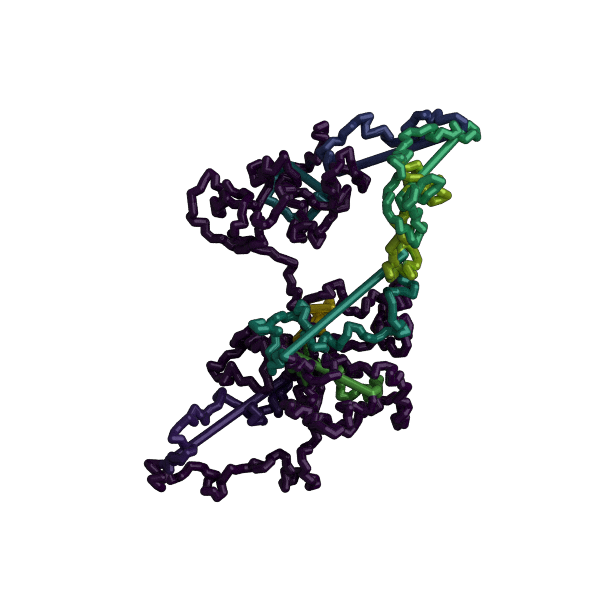

In [53]:
extrude.update_topology(system, translocator.lef_trajectory[0])
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show_loops=True, rescale_backbone_bonds=1).static()

In [54]:
system.run(1e5)

      160000           7151.31698     0:00:12.585095           1.04927          
Simulation.timestep  Simulation.tps     Status.etr    Thermo.kinetic_temperature
      160000           7151.31698     0:00:12.585095           1.04927          
      170000           7241.34435     0:00:11.047672           1.02209          
      170000           7241.34435     0:00:11.047672           1.02209          
      180000           7272.14813     0:00:09.625767           0.99246          
      180000           7272.14813     0:00:09.625767           0.99246          
      190000           7295.26823     0:00:08.224509           1.01184          
      190000           7295.26823     0:00:08.224509           1.01184          
      200000           7304.36190     0:00:06.845225           0.97133          
      200000           7304.36190     0:00:06.845225           0.97133          
      210000           7312.70985     0:00:05.469928           1.00640          
      210000           7312.

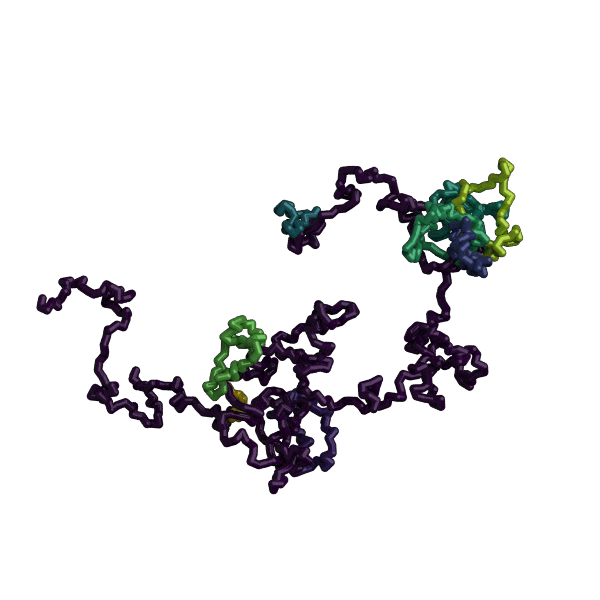

In [55]:
snapshot_looped = system.state.get_snapshot()
render.fresnel(snapshot_looped, show_loops=True, rescale_backbone_bonds=1).static()